## Segment Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [3]:
segment_ids = pd.read_csv('/Users/amytang10/Desktop/NYU_Capstone_Project/data_preprocessing/2023_full_segment_ids.csv', index_col=False)
segment_ids

,Unnamed: 0,Segment,ID
0,0,High-Value,"['000AHHU956', '000ENIY291', '000ESDW551', '00..."
1,1,Low-Value,"['000ELOE240', '000LZCB553', '000QEVH452', '00..."
2,2,Mid-Value,"['000BRHY264', '000DJKK225', '000EFUI271', '00..."


In [4]:
segment_ids["ID"] = segment_ids["ID"].apply(eval)  # Convert strings to lists
segment_df = segment_ids.explode("ID").reset_index(drop=True)
segment_df = segment_df[["ID", "Segment"]]
segment_df

,ID,Segment
0,000AHHU956,High-Value
1,000ENIY291,High-Value
2,000ESDW551,High-Value
3,000FBYF129,High-Value
4,000KREJ709,High-Value
...,...,...
40515,999SQRG442,Mid-Value
40516,999TUNB342,Mid-Value
40517,999URTX405,Mid-Value
40518,999WMMD928,Mid-Value


In [5]:
segment_df.groupby('Segment').count()

,ID
Segment,
High-Value,15252
Low-Value,7787
Mid-Value,17481


## Subcription Insights

In [6]:
# Join with Subcription data

sub_data = pd.read_csv('/Users/amytang10/Desktop/NYU_Capstone_Project/data_preprocessing/valid_full_sub.csv')

sub_df_segments = pd.merge(segment_df, sub_data, on='ID', how='inner')
sub_df_segments

,ID,Segment,Unnamed: 0,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,High-Value,0,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,High-Value,1,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,High-Value,5,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
3,000AHHU956,High-Value,6,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
4,000ENIY291,High-Value,28,RetroReel,paid,monthly,30.00,2022-11-04,2022-11,True
...,...,...,...,...,...,...,...,...,...,...
126001,999WMMD928,Mid-Value,219199,LimeLight,paid,annual,80.00,2022-05-31,2022-05,True
126002,999WVJU110,Mid-Value,219200,Pulse,expired,monthly,8.00,2022-04-21,2022-04,True
126003,999WVJU110,Mid-Value,219203,Pulse,paid,monthly,8.01,2022-09-14,2022-09,True
126004,999WVJU110,Mid-Value,219207,Pulse,expired,monthly,7.98,2023-08-25,2023-08,True


In [7]:
sub_high_value = sub_df_segments[sub_df_segments['Segment'] == 'High-Value']
sub_mid_value = sub_df_segments[sub_df_segments['Segment'] == 'Mid-Value']
sub_low_value = sub_df_segments[sub_df_segments['Segment'] == 'Low-Value']

In [9]:
def calculate_term_percentage(df):
    """
    Calculates the count and percentage of users that have monthly vs. annual subscription
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df['TERM'] = pd.Categorical(df['TERM'], categories=['monthly', 'annual'], ordered=True)
        df_deduplicated = df.sort_values('TERM', ascending=False).drop_duplicates(subset=['ID'])
        subscription_counts = df_deduplicated['TERM'].value_counts()
        subscription_percentages = df_deduplicated['TERM'].value_counts() / df['ID'].nunique()

    return subscription_counts, subscription_percentages

In [10]:
calculate_term_percentage(sub_high_value)

(TERM
 monthly    10756
 annual      3586
 Name: count, dtype: int64,
 TERM
 monthly    0.749965
 annual     0.250035
 Name: count, dtype: float64)

In [11]:
calculate_term_percentage(sub_mid_value)

(TERM
 annual     9427
 monthly    7452
 Name: count, dtype: int64,
 TERM
 annual     0.558505
 monthly    0.441495
 Name: count, dtype: float64)

In [12]:
calculate_term_percentage(sub_low_value)

(TERM
 annual     5230
 monthly    2551
 Name: count, dtype: int64,
 TERM
 annual     0.67215
 monthly    0.32785
 Name: count, dtype: float64)

In [123]:
def calculate_total_days(df):
    paid = False # Look for 'discounted', 'trial', 'paid'
    start = -1
    end = -1
    total_days = 0
    current_date = pd.to_datetime('2023-12-31')
    for i in range(len(df)):
        row = df.iloc[i,]
        if paid == True and row['SUB_STATUS'] == 'expired':
            paid = False
            end = row['PARTITION_DATE']
            total_days += (end - start).days

        if paid == False and row['SUB_STATUS'] in ['discounted', 'trial', 'paid']:
            paid = True
            start = row['PARTITION_DATE']

    if paid == True:
        end = current_date
        total_days += (end - start).days

    return total_days

In [251]:
def calculate_avg_sub_length(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        avg_days_list = []
        df["PARTITION_DATE"] = pd.to_datetime(df["PARTITION_DATE"])

        for ID, group in df.groupby('ID'):
            group = group.sort_values(by="PARTITION_DATE").reset_index(drop=True)  # Sort by date
            sub_length_by_brand = group.groupby('BRAND').apply(calculate_total_days)

            avg_days_list.append({"ID": ID, "Avg_sub_days": sub_length_by_brand.mean()})

        result_df = pd.DataFrame(avg_days_list)

    return result_df

In [252]:
# takes around 50 secs

high_value_sub_lengths = calculate_avg_sub_length(sub_high_value)
mid_value_sub_lengths = calculate_avg_sub_length(sub_mid_value)
low_value_sub_lengths = calculate_avg_sub_length(sub_low_value)

In [253]:
high_value_avg_sub_days = pd.DataFrame(high_value_sub_lengths.groupby('Avg_sub_days')['ID'].count()).reset_index()
high_value_avg_sub_days.columns = ['Avg_sub_days', 'Frequency']

mid_value_avg_sub_days = pd.DataFrame(mid_value_sub_lengths.groupby('Avg_sub_days')['ID'].count()).reset_index()
mid_value_avg_sub_days.columns = ['Avg_sub_days', 'Frequency']

low_value_avg_sub_days = pd.DataFrame(low_value_sub_lengths.groupby('Avg_sub_days')['ID'].count()).reset_index()
low_value_avg_sub_days.columns = ['Avg_sub_days', 'Frequency']

In [254]:
high_value_avg_sub_days["Category"] = "High-Value"
mid_value_avg_sub_days["Category"] = "Mid-Value"
low_value_avg_sub_days["Category"] = "Low-Value"

In [ ]:
combined_df = pd.concat([high_value_avg_sub_days, mid_value_avg_sub_days, low_value_avg_sub_days])

In [256]:
combined_df

,Avg_sub_days,Frequency,Category
0,1.0,1,High-Value
1,4.5,1,High-Value
2,5.0,1,High-Value
3,8.0,1,High-Value
4,9.0,1,High-Value
...,...,...,...
939,725.0,6,Low-Value
940,726.0,4,Low-Value
941,727.0,2,Low-Value
942,728.0,5,Low-Value


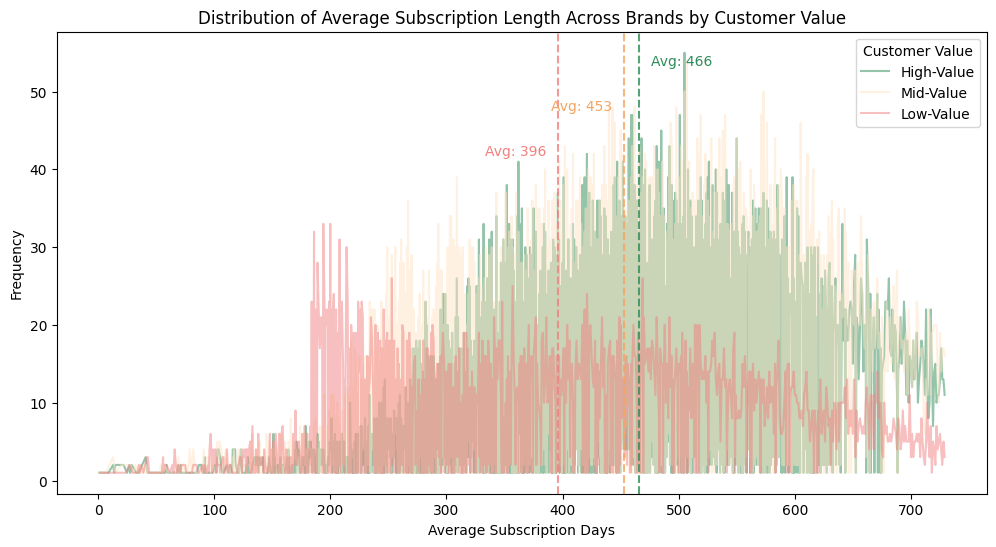

In [298]:
mean_high_value = round(high_value_sub_lengths['Avg_sub_days'].mean())
mean_mid_value = round(mid_value_sub_lengths['Avg_sub_days'].mean())
mean_low_value = round(low_value_sub_lengths['Avg_sub_days'].mean())

plt.figure(figsize=(12, 6))
color_palette = {'High-Value': 'seagreen', 'Mid-Value': 'bisque', 'Low-Value': 'lightcoral'}
sns.lineplot(data=combined_df, x='Avg_sub_days', y='Frequency', hue='Category', palette=color_palette, alpha=0.5)

plt.axvline(x=mean_high_value, color='seagreen', linestyle='--', alpha=0.8)
plt.axvline(x=mean_mid_value, color='sandybrown', linestyle='--', alpha=0.8)
plt.axvline(x=mean_low_value, color='lightcoral', linestyle='--', alpha=0.8)

offset = 10
plt.text(mean_high_value + offset, plt.ylim()[1]*0.95, f'Avg: {mean_high_value}', color='seagreen', verticalalignment='top', horizontalalignment='left')
plt.text(mean_mid_value - offset, plt.ylim()[1]*0.85, f'Avg: {mean_mid_value}', color='sandybrown', verticalalignment='top', horizontalalignment='right')
plt.text(mean_low_value - offset, plt.ylim()[1]*0.75, f'Avg: {mean_low_value}', color='lightcoral', verticalalignment='top', horizontalalignment='right')

plt.title('Distribution of Average Subscription Length Across Brands by Customer Value')
plt.xlabel('Average Subscription Days')
plt.ylabel('Frequency')
plt.legend(title='Customer Value')
plt.show()

In [ ]:
print(high_value_sub_lengths['Avg_sub_days'].mean())
print(mid_value_sub_lengths['Avg_sub_days'].mean())
print(low_value_sub_lengths['Avg_sub_days'].mean())

466.42062938688235
452.74171060686854
395.9205007925288


In [223]:
brands = ['ChillStream', 'CineQuest', 'LimeLight', 'Pulse', 'RetroReel']
high_value_brand_dist = list(round(sub_high_value.groupby('BRAND')['ID'].count() / len(sub_high_value), 2))
mid_value_brand_dist = list(round(sub_mid_value.groupby('BRAND')['ID'].count() / len(sub_mid_value), 2))
low_value_brand_dist = list(round(sub_low_value.groupby('BRAND')['ID'].count() / len(sub_low_value), 2))

sub_brand_dist_df = pd.DataFrame({'BRAND': brands,
                                  'High-Value': high_value_brand_dist,
                                  'Mid-Value': mid_value_brand_dist,
                                  'Low-Value': low_value_brand_dist})

sub_brand_dist_df

,BRAND,High-Value,Mid-Value,Low-Value
0,ChillStream,0.22,0.13,0.09
1,CineQuest,0.22,0.29,0.31
2,LimeLight,0.27,0.19,0.16
3,Pulse,0.11,0.30,0.38
4,RetroReel,0.17,0.09,0.07


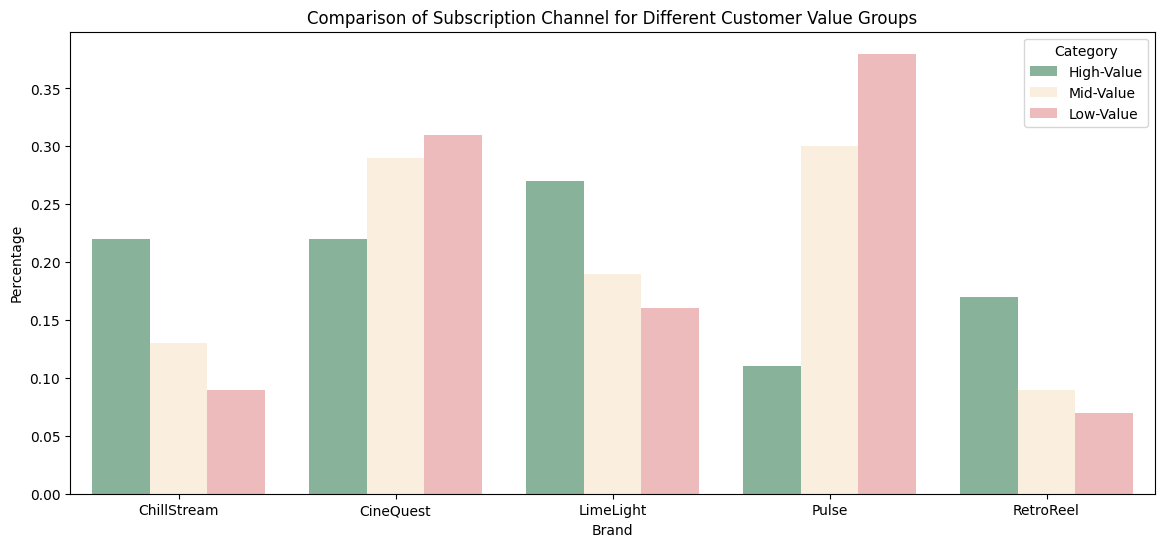

In [260]:
df_long = pd.melt(sub_brand_dist_df, id_vars='BRAND', value_vars=['High-Value', 'Mid-Value', 'Low-Value'], var_name='Category', value_name='Value')

plt.figure(figsize=(14, 6))
color_palette = {'High-Value': 'seagreen', 'Mid-Value': 'bisque', 'Low-Value': 'lightcoral'}
barplot = sns.barplot(data=df_long, x='BRAND', y='Value', hue='Category', palette=color_palette, alpha=0.6)

plt.title('Comparison of Subscription Channel for Different Customer Value Groups')
plt.xlabel('Brand')
plt.ylabel('Percentage')
plt.legend(title='Customer Value')
plt.legend(loc='upper right', title='Category')

plt.show()

## Online Content Insights

In [266]:
online_content_df = pd.read_csv('df_with_added_features.csv')

In [270]:
online_df_merged = pd.merge(online_content_df, segment_df, on='ID', how='inner')
online_df_merged = online_df_merged.drop(columns=['Unnamed: 0'])
online_df_merged.head()

,ID,URL,DATE,SCORE,Show,year,month,day,hour,dayofweek,...,BRAND,Most_Visited_Brand,Clicks_Per_Brand,Most_Watched_Show,Distinct_Shows_Watched,Distinct_Brands_Watched,Average_Score,Most_Active_Hour,Most_Active_DayofWeek,Segment
0,028ZIWM575,https://www.vodmedia.com/target-locked-episode-10,2023-05-23 17:26:54+00:00,0.44772,target locked,2023,5,23,17,2,...,Pulse,Pulse,5,highway heist,5,1,0.548858,17,6,Low-Value
1,467WUAP768,https://www.vodmedia.com/deep-waters-submarine...,2023-08-04 08:57:06+00:00,0.66931,deep waters submarine showdown,2023,8,4,8,5,...,Pulse,Pulse,4,stormfront: the final mission,4,1,0.683252,8,5,Low-Value
2,774ZQUY606,https://www.vodflix.com/target-locked-s2e5,2023-08-03 02:05:50+00:00,0.64074,target locked,2023,8,3,2,4,...,Pulse,Pulse,3,target locked,4,2,0.454717,2,1,Mid-Value
3,234FCFH350,https://www.vodmedia.com/the-last-outpost-s4e9,2023-02-05 15:24:11+00:00,0.86975,the last outpost,2023,2,5,15,7,...,Pulse,Pulse,7,highway heist,8,3,0.598760,3,3,Low-Value
4,796KJIH289,https://www.streammaster.com/movies/highway-he...,2022-04-06 17:55:41+00:00,0.92823,highway heist,2022,4,6,17,3,...,Pulse,Pulse,6,highway heist,4,2,0.693641,12,3,Mid-Value


In [271]:
online_df_merged.shape

(301580, 21)

In [291]:
# Top 3 visited brands per segment

visitor_counts = online_df_merged.groupby(['Segment', 'Most_Visited_Brand'])['ID'].nunique().reset_index(name='Unique_Visitors')
sorted_visitor_counts = visitor_counts.sort_values(['Segment', 'Unique_Visitors'], ascending=[True, False])
top3_brands_per_segment = sorted_visitor_counts.groupby('Segment').head(3)

top3_brands_per_segment

,Segment,Most_Visited_Brand,Unique_Visitors
5,High-Value,LimeLight,4229
8,High-Value,RetroReel,4087
1,High-Value,ChillStream,3060
19,Low-Value,Pulse,2616
14,Low-Value,CineQuest,2220
17,Low-Value,LimeLight,1276
31,Mid-Value,Pulse,3907
26,Mid-Value,CineQuest,3799
29,Mid-Value,LimeLight,3628


<div class="alert alert-info">

High value segment customers like to watch LimeLight, RetroReel, and ChillStream, of which RetroReel and ChillStream are not in the top 3 visited brand for mid and low value segments. Mid and low value segments exhibit the same brand-watching behavior, prioritizing Pulse and CineQuest.

LimeLight, RetroReel, and ChillStream focus more on Reality TV, Lifestyle, Documentary, Nature, Travel, Classic Films or TV shows for older generation and cinephiles. These charateristics combined all show that high value segment customers might be of older age, and the content they are consuming naturally cost more (travel, film, nature, etc). Therefore, they present higher value to the company as they might be a loyal subscriber to the channels.

On the other hand, mid and low value segment customers prefer Pulse, which is for Action, Thriller, Adventure, and High-Energy contents, which naturally appeal to a younger age group. CineQuest is for Film Series, High-Quality Drama, which also has a time-sensative nature. Viewers might unsubscribe after a certaim series end, and they might subscribe when the series they want to watch release. High value customers might constantly subscribe as a lifestyle thing, instead of a come and go manner.

</div>

In [303]:
online_df_merged.groupby('Segment')['Clicks_Per_Brand'].count()

Segment
High-Value    118545
Low-Value      52798
Mid-Value     130237
Name: Clicks_Per_Brand, dtype: int64

In [310]:
online_high_df = online_df_merged[online_df_merged['Segment'] == 'High-Value']
online_mid_df = online_df_merged[online_df_merged['Segment'] == 'Mid-Value']
online_low_df = online_df_merged[online_df_merged['Segment'] == 'Low-Value']

In [315]:
high_hour = online_high_df.groupby('Most_Active_Hour')['ID'].count().reset_index()
high_hour.columns = ['Most_Active_Hour', 'Frequency']

mid_hour = online_mid_df.groupby('Most_Active_Hour')['ID'].count().reset_index()
mid_hour.columns = ['Most_Active_Hour', 'Frequency']

low_hour = online_low_df.groupby('Most_Active_Hour')['ID'].count().reset_index()
low_hour.columns = ['Most_Active_Hour', 'Frequency']

In [325]:
high_dayofweek = online_high_df.groupby('Most_Active_DayofWeek')['ID'].count().reset_index()
high_dayofweek.columns = ['Most_Active_DayofWeek', 'Frequency']

mid_dayofweek = online_mid_df.groupby('Most_Active_DayofWeek')['ID'].count().reset_index()
mid_dayofweek.columns = ['Most_Active_DayofWeek', 'Frequency']

low_dayofweek = online_low_df.groupby('Most_Active_DayofWeek')['ID'].count().reset_index()
low_dayofweek.columns = ['Most_Active_DayofWeek', 'Frequency']

In [318]:
high_hour["Category"] = "High-Value"
mid_hour["Category"] = "Mid-Value"
low_hour["Category"] = "Low-Value"

In [319]:
online_combined_df = pd.concat([high_hour, mid_hour, low_hour])

online_combined_df

,Most_Active_Hour,Frequency,Category
0,0,13578,High-Value
1,1,11655,High-Value
2,2,9860,High-Value
3,3,8501,High-Value
4,4,7832,High-Value
...,...,...,...
19,19,1014,Low-Value
20,20,913,Low-Value
21,21,1145,Low-Value
22,22,911,Low-Value


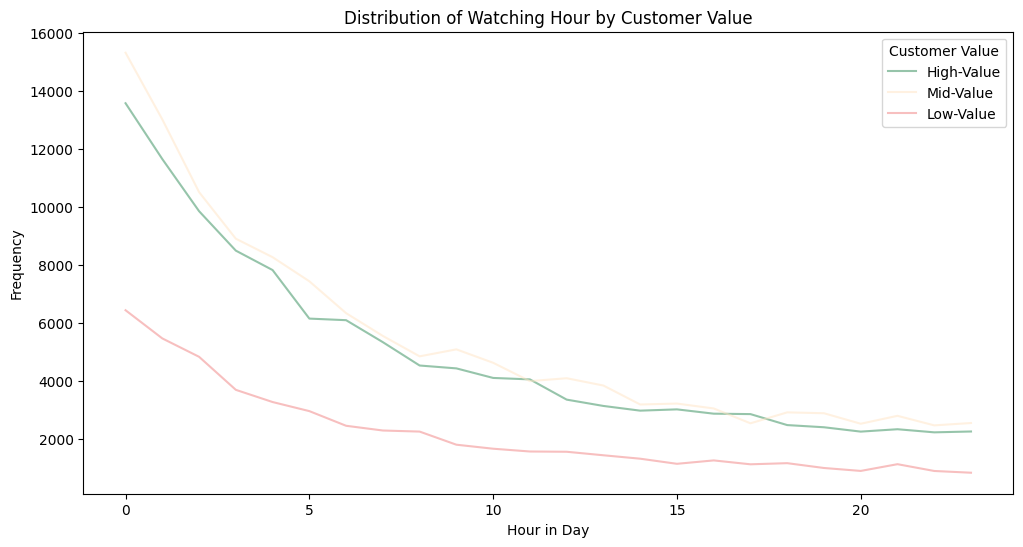

In [331]:
mean_high_hour = round(high_hour['Most_Active_Hour'].mean())
mean_mid_hour = round(mid_hour['Most_Active_Hour'].mean())
mean_low_hour = round(low_hour['Most_Active_Hour'].mean())

plt.figure(figsize=(12, 6))
color_palette = {'High-Value': 'seagreen', 'Mid-Value': 'bisque', 'Low-Value': 'lightcoral'}
sns.lineplot(data=online_combined_df, x='Most_Active_Hour', y='Frequency', hue='Category', palette=color_palette, alpha=0.5)

# plt.axvline(x=mean_high_hour, color='seagreen', linestyle='--', alpha=0.8)
# plt.axvline(x=mean_mid_hour, color='sandybrown', linestyle='--', alpha=0.8)
# plt.axvline(x=mean_low_hour, color='lightcoral', linestyle='--', alpha=0.8)

# offset = 10
# plt.text(mean_high_hour + offset, plt.ylim()[1]*0.95, f'Avg: {mean_high_hour}', color='seagreen', verticalalignment='top', horizontalalignment='left')
# plt.text(mean_mid_hour - offset, plt.ylim()[1]*0.85, f'Avg: {mean_mid_hour}', color='sandybrown', verticalalignment='top', horizontalalignment='right')
# plt.text(mean_low_hour - offset, plt.ylim()[1]*0.75, f'Avg: {mean_low_hour}', color='lightcoral', verticalalignment='top', horizontalalignment='right')

plt.title('Distribution of Watching Hour by Customer Value')
plt.xlabel('Hour in Day')
plt.ylabel('Frequency')
plt.legend(title='Customer Value')
plt.show()

## Viewership Insights